# Using SVM to predict a continuous label not a category

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
df = pd.read_csv('../DATA/cement_slump.csv')

In [5]:
df.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


<AxesSubplot:>

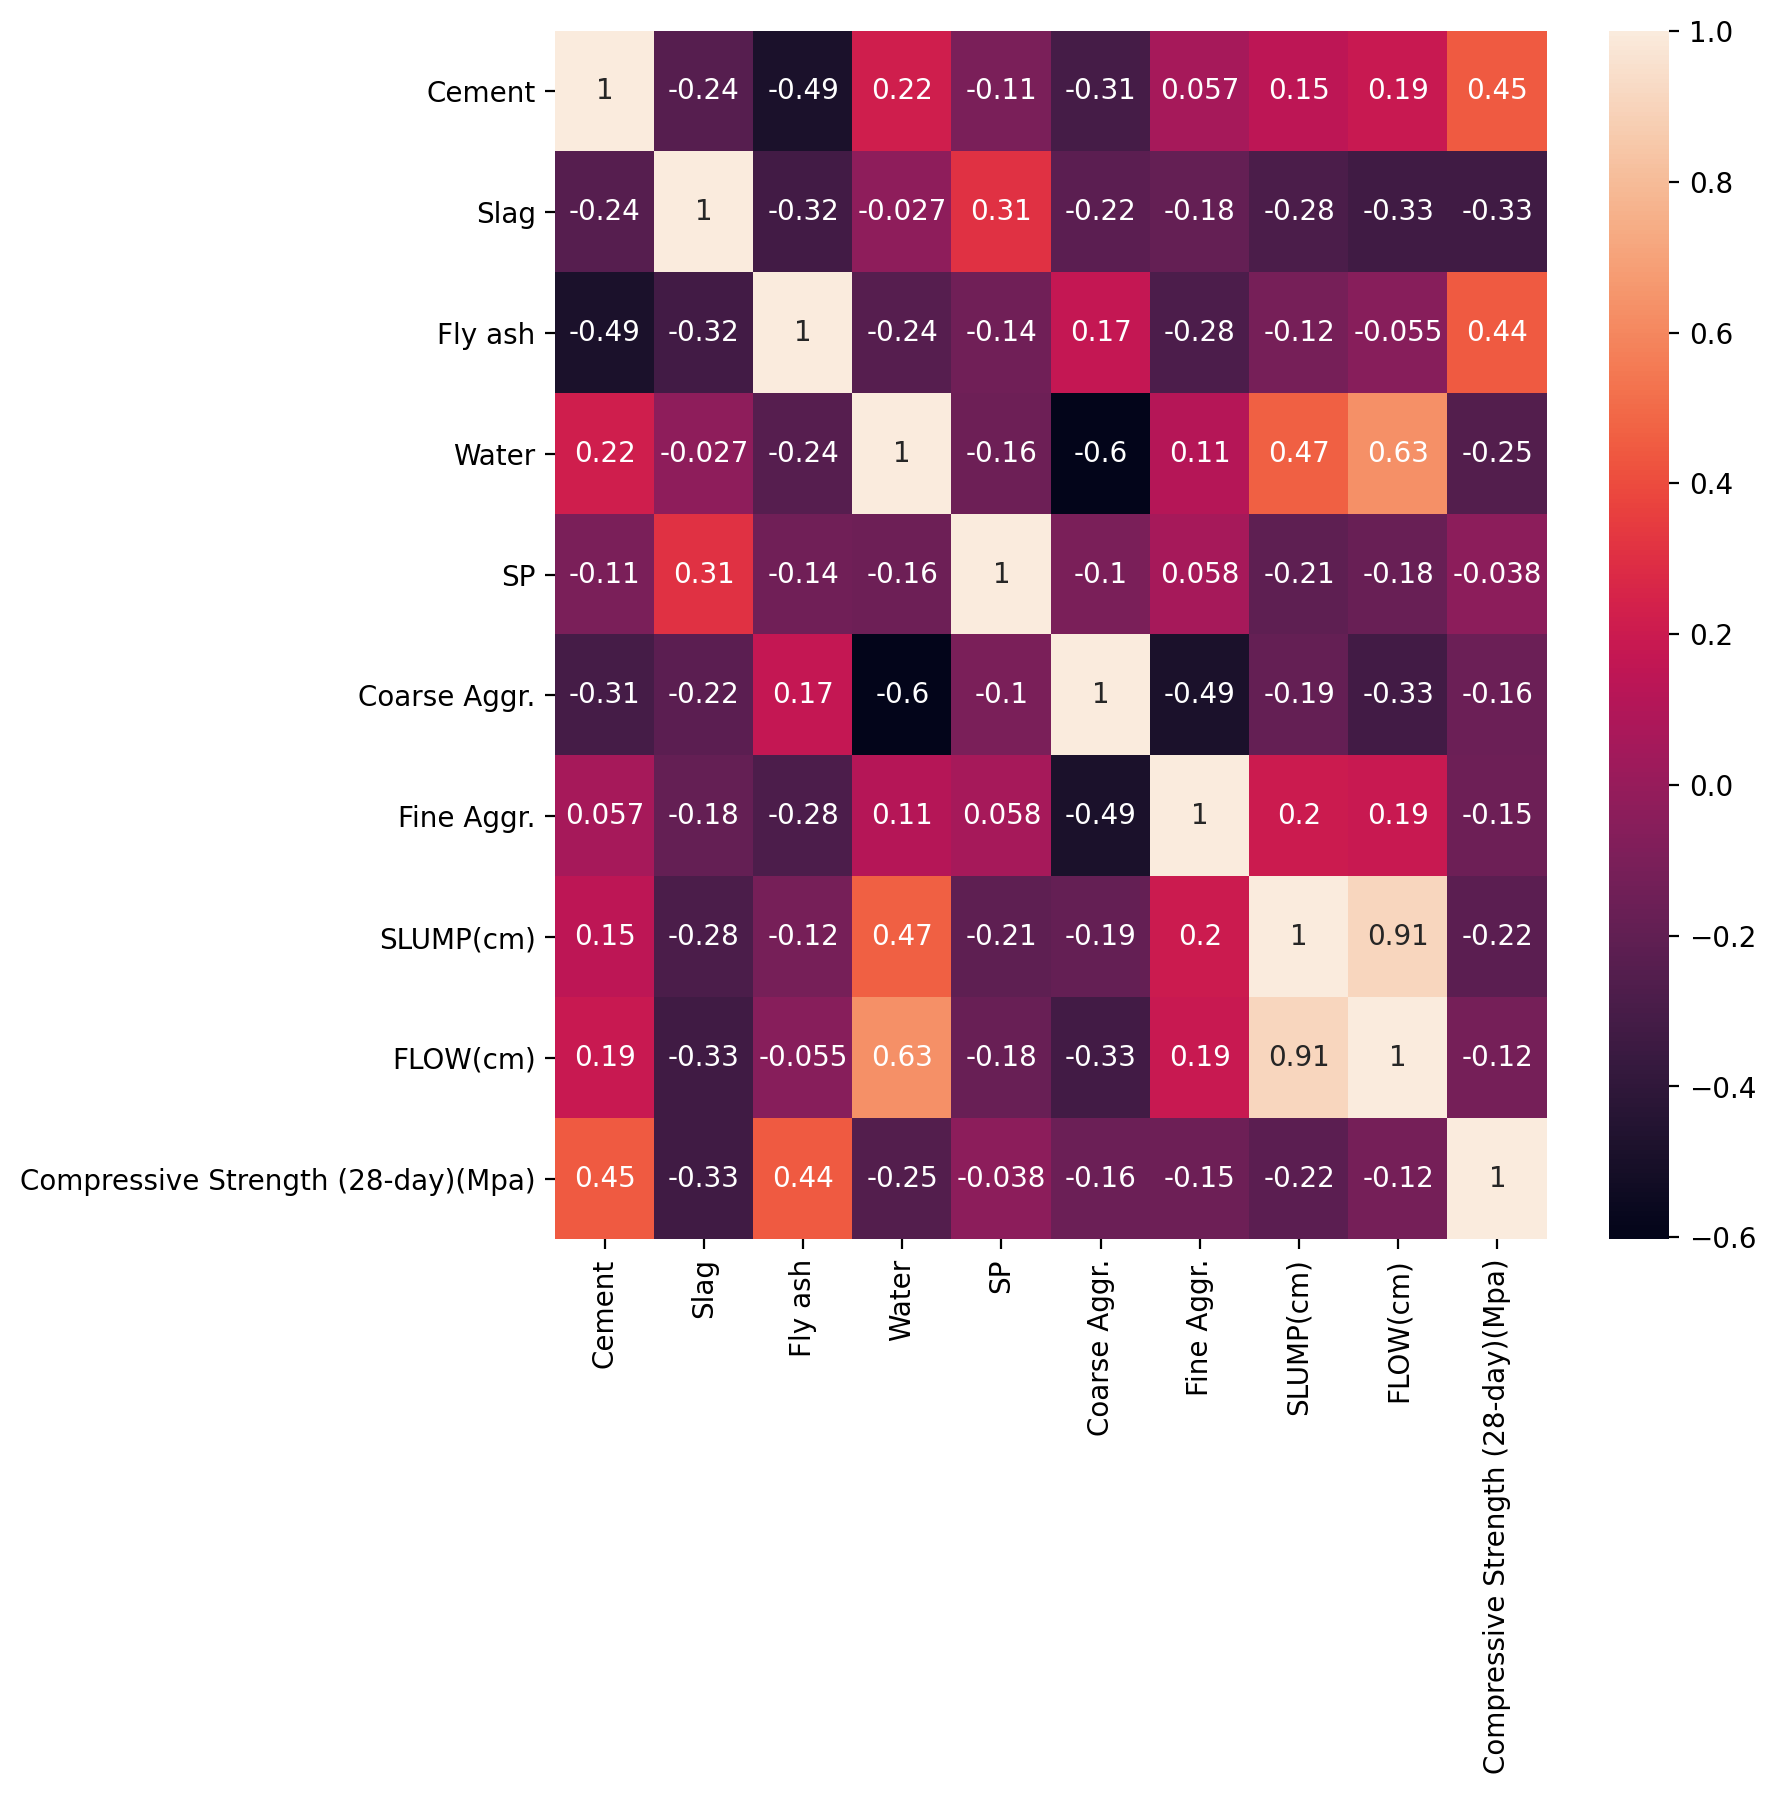

In [7]:
plt.figure(figsize=(8, 8), dpi=200)
sns.heatmap(df.corr(), annot=True)

In [8]:
df.columns

Index(['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.',
       'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)',
       'Compressive Strength (28-day)(Mpa)'],
      dtype='object')

In [9]:
X = df.drop('Compressive Strength (28-day)(Mpa)', axis=1)

In [10]:
y = df['Compressive Strength (28-day)(Mpa)']

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [13]:
# May as well always scale (expecially for SVMs) it has no downsides
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()

In [15]:
scaled_X_train = scaler.fit_transform(X_train)

In [16]:
scaled_X_test = scaler.transform(X_test)

In [17]:
# For regression
# Only use LinearSVR if you know you are using the linear kernel
from sklearn.svm import SVR, LinearSVR # SVR = Support Vector Regression

In [18]:
# 'epsilon' denotes how much err we aere going to allow for each training data instance (we don't want it to be 0 because it could cause overfitting)
help(SVR)

Help on class SVR in module sklearn.svm._classes:

class SVR(sklearn.base.RegressorMixin, sklearn.svm._base.BaseLibSVM)
 |  SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
 |  
 |  Epsilon-Support Vector Regression.
 |  
 |  The free parameters in the model are C and epsilon.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to datasets with more than a couple of 10000 samples. For large
 |  datasets consider using :class:`~sklearn.svm.LinearSVR` or
 |  :class:`~sklearn.linear_model.SGDRegressor` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  Read more in the :ref:`User Guide <svm_regression>`.
 |  
 |  Parameters
 |  ----------
 |  kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
 |       Specifies th

In [19]:
base_model = SVR()

In [20]:
# Try all defaults then check out grid search.
base_model.fit(scaled_X_train, y_train)

SVR()

In [21]:
base_preds = base_model.predict(scaled_X_test)

In [22]:
# Metrics...
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [23]:
mean_absolute_error(y_test, base_preds)

5.236902091259179

In [24]:
# Can we improve on this?
np.sqrt(mean_squared_error(y_test, base_preds))

6.695914838327134

In [25]:
y_test.mean()

36.26870967741935

In [27]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4], # May get warning because some kernels will ignore this
    'epsilon': [0, 0.01, 0.1, 0.5, 1, 2]
}

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
svr = SVR()

In [30]:
grid = GridSearchCV(svr, param_grid)

In [32]:
grid.fit(scaled_X_train, y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1], 'degree': [2, 3, 4],
                         'epsilon': [0, 0.01, 0.1, 0.5, 1, 2],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']})

In [33]:
grid.best_params_

{'C': 1, 'degree': 2, 'epsilon': 2, 'gamma': 'scale', 'kernel': 'linear'}

In [34]:
# New performance?
grid_preds = grid.predict(scaled_X_test)

In [35]:
mean_absolute_error(y_test, grid_preds)

2.512801221076172

In [37]:
# Amazing improvement!
np.sqrt(mean_squared_error(y_test, grid_preds))

3.178210305119806